# Creating an AI model from scratch

In [ ]:
#Import neccessary libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

Convert data set into numpy array
In this session, we are using "Housing Dataset of 5000 people staying in USA" provided by kaggle in the form of an .csv file

Source: https://www.kaggle.com/datasets/darshanprabhu09/housing-dataset-of-5000-people-staying-in-usa?resource=download

In [ ]:
#Fixing the csv file
#You only need to run this code block ONCE when you first downloaded the source dataset.
#Because (somehow) the original csv file is unusable, we need to do some formatting with simple read/write operations.
srcfile = open('USA_Housing.csv','r+')
destfile = open('USA_Housing_Fixed.csv','w')

srclist = srcfile.readlines()
for i in range(len(srclist)):
    if i == 0:
        continue
    if i % 2 != 0:
        destfile.write(srclist[i].rpartition(",\"")[0] + "\n")

In [ ]:
dataset = np.genfromtxt('USA_Housing_Fixed.csv',delimiter=',',dtype='float64')
dataset

We split the prices column, which is the value we want to predict (targets)

In [ ]:
targets = dataset[:, 5]
dataset = np.delete(dataset, 5, 1)
dataset

Next, we split the dataset into train and test data.

In [ ]:
dataset_train, dataset_test, targets_train, targets_test = train_test_split(dataset, targets, test_size=0.2, random_state=0)

Model's basis for evaluation
- Using cosine similarity as our evaluation method.
- We calculate the cosine similarity of the input vector with multiple weight vectors, then we add all results together. (Layer 1)
- Because the given dataset follows Gaussian probability (continous values), we need to pass the result to an activation function. (Layer 2)
- For this session, our activation function is Sigmoid activation function

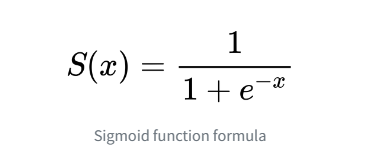

- If the output is greater than 0.5, we return TRUE. Otherwise FALSE.

In [ ]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def tanh(x):
    return (np.exp(x) - np.exp(-x))/(np.exp(x) + np.exp(-x))
def derivative_tanh(x):
     return 1 - np.square(tanh(x))
def make_prediction(input_vector, weights, bias):
    layer_1 = np.dot(input_vector, weights)/(np.linalg.norm(input_vector)*np.linalg.norm(weights)) + bias
    layer_2 = sigmoid(layer_1)
    return layer_2
def _cosine_similarity(input_vector, weights):
        return np.dot(input_vector, weights)/(np.linalg.norm(input_vector)*np.linalg.norm(weights))
input_vector = dataset[5]
weights = np.array([2.5,3,1,-0.6,2])
bias = np.array([0.0])
result = _cosine_similarity(input_vector, weights) + bias
#result = input_vector/(np.linalg.norm(input_vector) * np.linalg.norm(weights)) - _cosine_similarity(input_vector, weights)*(weights/np.square(np.linalg.norm(weights)))
tanh(result)

# Create the neural network model class
- Because the data values are quite large, we cannot compute using the dot product.
- Instead, the **cosine_similarity** is used.
- Thank you to https://math.stackexchange.com/questions/1923613/partial-derivative-of-cosine-similarity for providing the formula to the derivative of cosine similarity!

In [ ]:
class MyModel:
    def __init__(self, learning_rate) -> None:
        self.weights = np.array([np.random.randn(), np.random.randn(), np.random.rand(), np.random.randn(), np.random.randn()])
        self.bias = np.random.randn()
        self.learning_rate = learning_rate
    
    def _sigmoid(self, x):
        return 1 / (1 + np.exp(-x))
    def _derivative_sigmoid(self, x):
        return self._sigmoid(x) * (1-self._sigmoid(x))
    
    def _cosine_similarity(self, input_vector):
        return np.dot(input_vector, self.weights)/(np.linalg.norm(input_vector)*np.linalg.norm(self.weights))
    def _derivative_cosine_similarity_byWeights(self, input_vector):
        return input_vector/(np.linalg.norm(input_vector) * np.linalg.norm(self.weights)) - self._cosine_similarity(input_vector)*(self.weights/np.square(np.linalg.norm(self.weights)))
    
    def _tanh(self, x):
        return (np.exp(x) - np.exp(-x))/(np.exp(x) + np.exp(-x))
    def _derivative_tanh(self, x):
        return 1 - np.square(tanh(x))
    
    def predict(self, input_vector):
        layer_1 = self._cosine_similarity(input_vector)
        layer_2 = self._sigmoid(layer_1 * 5) * self.bias
        return layer_2 
    
    def _compute_gradients(self, input_vector, target):
        layer_1 = self._cosine_similarity(input_vector)
        layer_2 = self._sigmoid(layer_1 * 5) * self.bias
        prediction = layer_2

        derror_dprediction = 2 * (prediction - target) #MSE
        dprediction_dlayer1 = self._derivative_sigmoid(layer_1 * 5) * self.bias * 5
        dprediction_dbias = self._sigmoid(layer_1 * 5) 
        dlayer1_dweights = self._derivative_cosine_similarity_byWeights(input_vector)

        derror_dbias = (
            derror_dprediction * dprediction_dbias
        )
        derror_dweights = (
            derror_dprediction * dprediction_dlayer1 * dlayer1_dweights
        )
        return derror_dbias, derror_dweights

    def _update_parameters(self, derror_dbias, derror_dweights):
        self.bias = self.bias - (derror_dbias * self.learning_rate)
        self.weights = self.weights - (
            derror_dweights * self.learning_rate
        )
        return derror_dbias, derror_dweights
    
    def train(self, input_vectors, targets, epochs=5):
        """
        Train the model

        input_vectors: array of input vectors
        targets: array of target values that corresponds to input vectors
        epochs: number of iterations (default is 5)
        """
        cumulative_errors = []
        for current_iteration in range(epochs):
            # Pick a data instance at random
            random_data_index = np.random.randint(len(input_vectors))

            input_vector = input_vectors[random_data_index]
            target = targets[random_data_index]

            # Compute the gradients and update the weights
            derror_dbias, derror_dweights = self._compute_gradients(
                input_vector, target
            )

            self._update_parameters(derror_dbias, derror_dweights)

            # Measure the cumulative error for all the instances
            if current_iteration % 100 == 0:
                cumulative_error = 0
                # Loop through all the instances to measure the error
                for data_instance_index in range(len(input_vectors)):
                    data_point = input_vectors[data_instance_index]
                    target = targets[data_instance_index]

                    prediction = self.predict(data_point)
                    error = np.square(prediction - target)

                    cumulative_error = cumulative_error + error
                cumulative_errors.append(cumulative_error)
        return cumulative_errors
    
    def fit(self, input_vectors, targets):
        """
        Test the model.
        Outputs the overall accuracy of the model.
        """
        cummulative_precisions = 0
        for i in range(len(input_vectors)):
            prediction = self.predict(input_vectors[i])
            precision = 1 - ((prediction - targets[i]) / targets[i])
            cummulative_precisions = cummulative_precisions + precision
        return cummulative_precisions / len(input_vectors)


Insantitate the class.

In [ ]:
alpha = 0.1
model = MyModel(alpha)
model.predict(dataset_test[1])

The prediction is pretty horrible right now, but let's train our model.

In [ ]:
cummulative_errors = model.train(dataset_train, targets_train, epochs=5000)

In [ ]:
plt.plot(cummulative_errors)
plt.xlabel("Iterations")
plt.ylabel("Error for all training instances")

In [ ]:
model_precision = model.fit(dataset_test, targets_test)
print(f"Model precision through test dataset is {model_precision}")

So, through training and implementing different activation functions, we have reached an accuracy of *about* **71-74%**. Still not economically optimal, but it is a good start.

# Conclusion
- Preprocessing input data is important

- Input layer of the neural network is crucial. For large values, it is wise to use functions that reduces them to a result that can be efficiently passed to the activation function, while still witholding the relationships between all variables.

- For example, at the beginning I had planned to use **dot product** of the input vector and weight vector, but the result turned out to be too large (or too small), which causes the activation function (Sigmoid's) to be inconclusive. By replacing layer 1 with the **cosine_similarity** instead - with a range of (-1, 1) - and extending the range to (-5, 5), I was able to utilize the Sigmoid's activation function.

- Clearly, this model can still be improved drastically. Mind the fact that the training dataset is still quite small (only 5000 entries).